In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.utils import Sequence
from tqdm import tqdm
import math
import json
import pickle

In [2]:
id_tuples = []
with open('./raw_data/v2_mscoco_train2014_annotations.json') as f:
    data = json.load(f)
    for annotation in data['annotations']:
        if annotation['answer_type'] == 'yes/no':
            id_tuples.append((annotation['question_id'], annotation['image_id'], annotation['multiple_choice_answer']))        
print(len(id_tuples))

questions = {}
with open('./raw_data/v2_OpenEnded_mscoco_train2014_questions.json') as f:
    data = json.load(f)
    for question in data['questions']:
        questions[question['question_id']] = question['question']
pickle.dump(questions, open('./processed_data/questions.npy', 'wb'))

result = []
for id_tuple in tqdm(id_tuples):
    question = questions[id_tuple[0]]
    img = 'COCO_train2014_' + str(id_tuple[1]).zfill(12) + '.jpg'
    result.append((question, img, id_tuple[-1]))
np.save('./processed_data/train_data_ids.npy', result)

166882
100%|██████████| 166882/166882 [00:00<00:00, 695367.20it/s]


In [6]:
class VQASequenceInMem(Sequence):

    def __init__(self, batch_size, tuple_path,transform=None):
        data_tuples = np.load(tuple_path)
        self.transform = transform
        self.imgs = []
        self.qs = []
        self.answers = []
        self.batch_size = batch_size
        for ids in tqdm(data_tuples, desc="Loading everything into memory"):
            q, img_id, answer = ids
            img = Image.open('./raw_data/train2014/' + img_id).convert('RGB')
            img = tf.keras.preprocessing.image.img_to_array(img)
            self.imgs.append(img)
            self.qs.append(q)
            self.answers.append(answer)
    
    def __getitem__(self, idx):
        q_batch = self.q[idx * self.batch_size:(idx + 1) * self.batch_size]
        i_batch = self.imgs[idx * self.batch_size:(idx + 1) * self.batch_size]
        a_batch = self.answers[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array([q_batch, i_batch]), a_batch
    
    def __len__(self):
        return math.ceil(len(self.imgs) / self.batch_size)
    
class VQASequence(Sequence):

    def __init__(self, batch_size, tuple_path,transform=None):
        data_tuples = np.load(tuple_path)
        self.transform = transform
        self.img_ids = []
        self.qs = []
        self.answers = []
        self.batch_size = batch_size
        for ids in tqdm(data_tuples):
            q, img_id, answer = ids
            self.img_ids.append(img_id)
            self.qs.append(q)
            self.answers.append(answer)
    
    def __getitem__(self, idx):
        q_batch = self.qs[idx * self.batch_size:(idx + 1) * self.batch_size]
        i_ids = self.img_ids[idx * self.batch_size:(idx + 1) * self.batch_size]
        a_batch = self.answers[idx * self.batch_size:(idx + 1) * self.batch_size]
        i_batch = []
        for id in i_ids:
            img = Image.open('./raw_data/train2014/' + id).convert('RGB')
            img = tf.keras.preprocessing.image.img_to_array(img)
            i_batch.append(img)
        return (q_batch, i_batch), a_batch
    
    def __len__(self):
        return math.ceil(len(self.img_ids) / self.batch_size)


100%|██████████| 166882/166882 [00:00<00:00, 292393.77it/s]
Is there a flower pattern on the dish?
yes


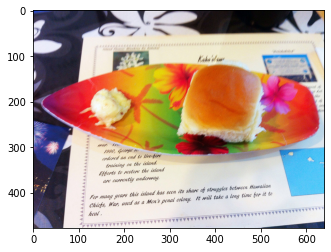

In [9]:
import matplotlib.pyplot as plt
BATCH_SIZE = 64
# Load all train data into mem
# dataset = VQASequenceInMem(BATCH_SIZE, './processed_data/train_data_ids.npy')
# Load one batch at a time
dataset = VQASequence(BATCH_SIZE, './processed_data/train_data_ids.npy')

rand_idx = np.random.randint(len(dataset))
rand_batch_idx = np.random.randint(BATCH_SIZE)

(q_batch, i_batch), a_batch = dataset[rand_idx]
q, i, a = q_batch[rand_batch_idx], i_batch[rand_batch_idx], a_batch[rand_batch_idx]

print(q)
print(a)
plt.imshow(i/255.0)